# Import Libraries

This cell imports all the necessary libraries for data processing, visualization, modeling, and evaluation.

> Add blockquote



In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import joblib



# Load the Dataset

In [2]:
# Load the dataset
df = pd.read_csv('cropyield_df.csv')

In [3]:
df.head()

,Unnamed: 0,Area,Item,Year,hg/ha_yield,average_rain_fall_mm_per_year,pesticides_tonnes,avg_temp
0,0,Albania,Maize,1990,36613,1485.0,121.0,16.37
1,1,Albania,Potatoes,1990,66667,1485.0,121.0,16.37
2,2,Albania,"Rice, paddy",1990,23333,1485.0,121.0,16.37
3,3,Albania,Sorghum,1990,12500,1485.0,121.0,16.37
4,4,Albania,Soybeans,1990,7000,1485.0,121.0,16.37


# Dataset Cleaning

data cleaning, including checking for missing values, dropping unnecessary columns, handling missing values, and removing duplicates.

In [4]:
# --- Dataset Cleaning ---
print("Initial Dataset Info:")
print(df.info())
print("\nMissing Values:")
print(df.isnull().sum())

# Drop unnecessary index column if present
if df.columns[0].startswith('Unnamed'):
    df = df.drop(df.columns[0], axis=1)

# Handle missing values (if any)
df = df.dropna()  # Drop rows with missing values (can be adjusted based on dataset)

# Check for duplicates and remove them
print("\nNumber of Duplicates:", df.duplicated().sum())
df = df.drop_duplicates()

Initial Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28242 entries, 0 to 28241
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Unnamed: 0                     28242 non-null  int64  
 1   Area                           28242 non-null  object 
 2   Item                           28242 non-null  object 
 3   Year                           28242 non-null  int64  
 4   hg/ha_yield                    28242 non-null  int64  
 5   average_rain_fall_mm_per_year  28242 non-null  float64
 6   pesticides_tonnes              28242 non-null  float64
 7   avg_temp                       28242 non-null  float64
dtypes: float64(3), int64(3), object(2)
memory usage: 1.7+ MB
None

Missing Values:
Unnamed: 0                       0
Area                             0
Item                             0
Year                             0
hg/ha_yield                      0
average_rai

# Exploratory Data Analysis (EDA) - Basic Statistics

This cell prints basic statistics of the dataset using describe() to understand the numerical features.

In [5]:
# --- Exploratory Data Analysis (EDA) ---
# Basic statistics
print("\nDataset Description:")
print(df.describe())


Dataset Description:
               Year    hg/ha_yield  average_rain_fall_mm_per_year  \
count  25932.000000   25932.000000                   25932.000000   
mean    2001.556455   76978.132925                    1146.836688   
std        7.055924   84647.605552                     717.391098   
min     1990.000000      50.000000                      51.000000   
25%     1995.000000   19996.000000                     593.000000   
50%     2001.000000   39530.000000                    1083.000000   
75%     2008.000000  104168.000000                    1668.000000   
max     2013.000000  501412.000000                    3240.000000   

       pesticides_tonnes      avg_temp  
count       25932.000000  25932.000000  
mean        34782.573241     20.422251  
std         57228.568244      6.439402  
min             0.040000      1.300000  
25%          1597.000000     16.580000  
50%         15373.000000     21.420000  
75%         45620.000000     26.060000  
max        367778.000000    

# EDA - Distribution of Numerical Features

This cell visualizes the distribution of numerical features using histograms with kernel density estimation (KDE).

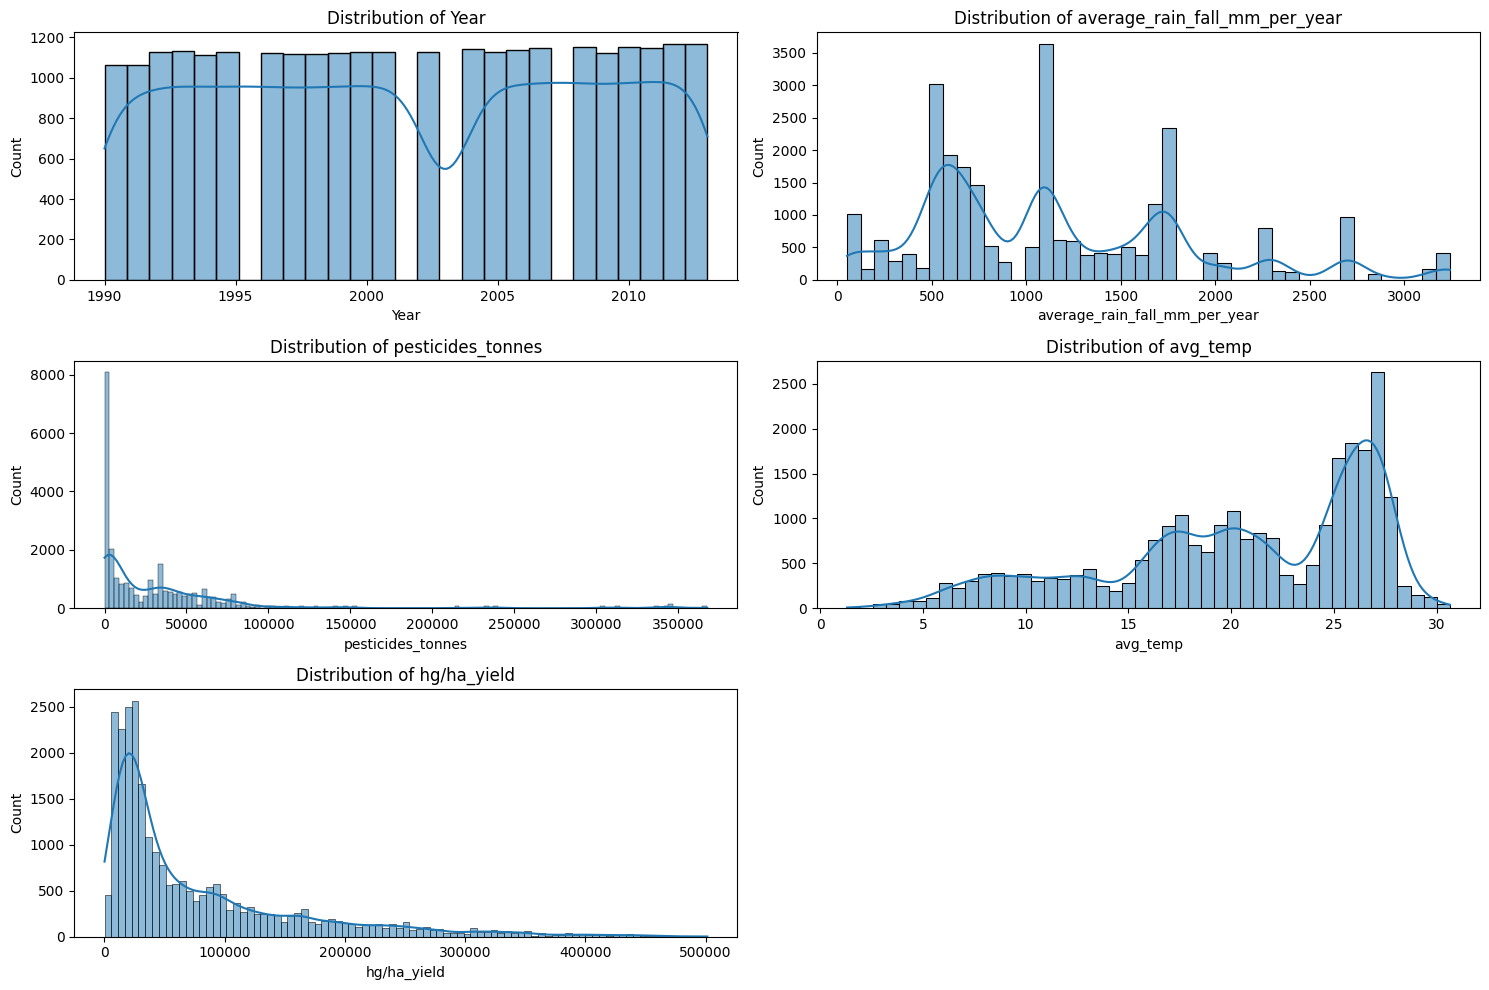

In [6]:
# Distribution of numerical features
numerical_cols = ['Year', 'average_rain_fall_mm_per_year', 'pesticides_tonnes', 'avg_temp', 'hg/ha_yield']
plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(3, 2, i)
    sns.histplot(df[col], kde=True)
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

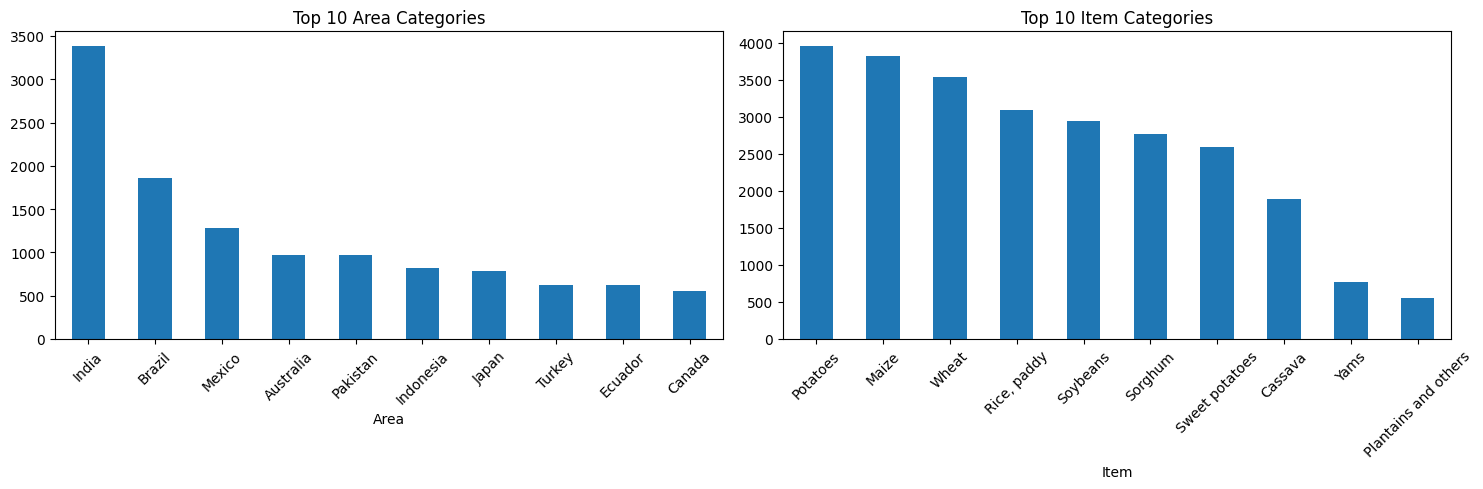

In [7]:
# Distribution of categorical features
categorical_cols = ['Area', 'Item']
plt.figure(figsize=(15, 5))
for i, col in enumerate(categorical_cols, 1):
    plt.subplot(1, 2, i)
    df[col].value_counts().head(10).plot(kind='bar')
    plt.title(f'Top 10 {col} Categories')
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [17]:

# Bin the target variable 'hg/ha_yield' into Low, Medium, High
yield_bins = pd.qcut(df['hg/ha_yield'], q=3, labels=['Low', 'Medium', 'High'])
df['yield_category'] = yield_bins

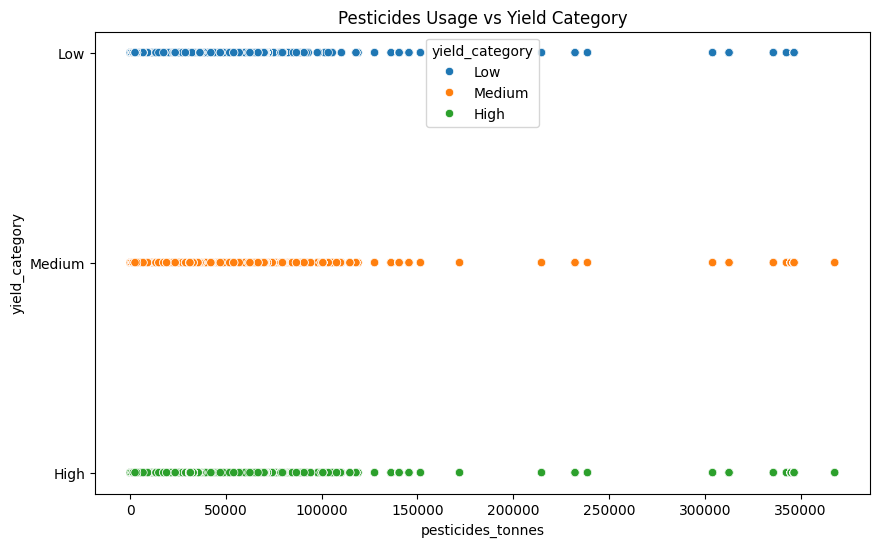

In [18]:
# Visualization  Pesticides vs Yield
plt.figure(figsize=(10, 6))
sns.scatterplot(x='pesticides_tonnes', y='yield_category', hue='yield_category', data=df)
plt.title('Pesticides Usage vs Yield Category')
plt.show()


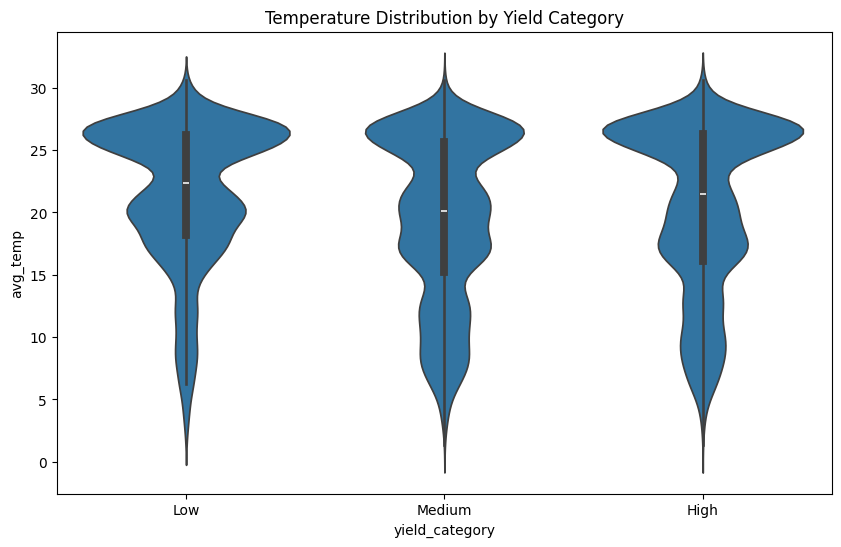

In [19]:

# Visualization: Temperature vs Yield
plt.figure(figsize=(10, 6))
sns.violinplot(x='yield_category', y='avg_temp', data=df)
plt.title('Temperature Distribution by Yield Category')
plt.show()


**Interpretation & Insights of violin plot**

Temperature distribution is similar across all yield categories. No clear trend linking temperature to higher or lower yields.

Extreme temperatures occur in all categories. Some outliers exist, but they don’t strongly affect yield.



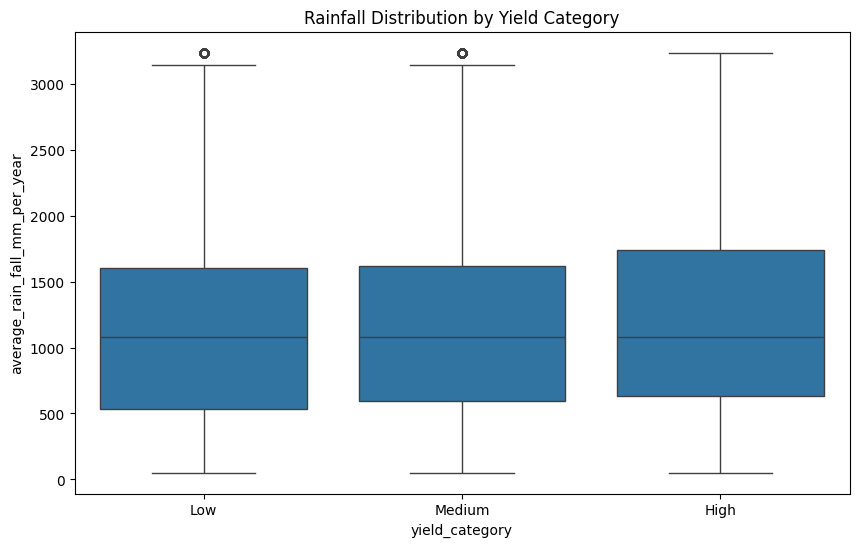

In [20]:
# Visualization : Rainfall vs Yield
plt.figure(figsize=(10, 6))
sns.boxplot(x='yield_category', y='average_rain_fall_mm_per_year', data=df)
plt.title('Rainfall Distribution by Yield Category')
plt.show()


**Interpretation of the Box Plot**

Rainfall alone does not determine crop yield. Median rainfall is similar across all yield categories.

High rainfall does not guarantee high yield. Outliers suggest excessive rainfall may not improve yields.


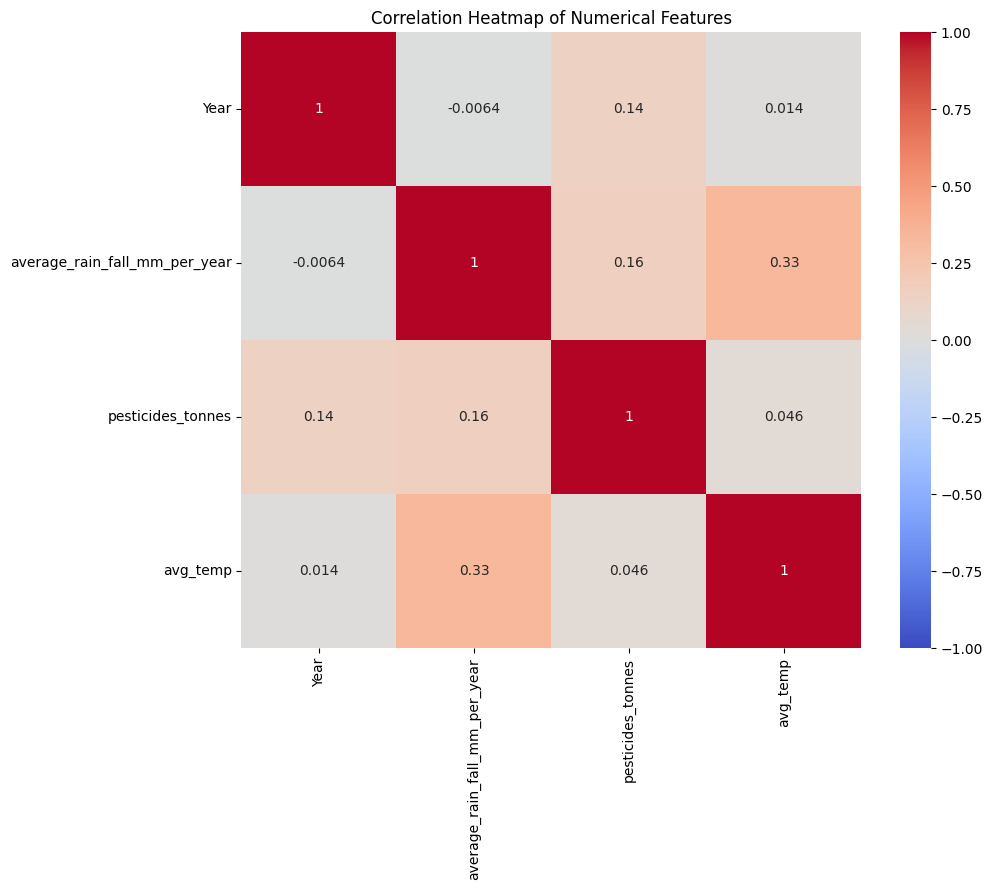

In [21]:



# Visualization  Correlation Heatmap
plt.figure(figsize=(10, 8))
numerical_df = df[['Year', 'average_rain_fall_mm_per_year', 'pesticides_tonnes', 'avg_temp']]
sns.heatmap(numerical_df.corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap of Numerical Features')
plt.show()


# Detailed Outlier Analysis

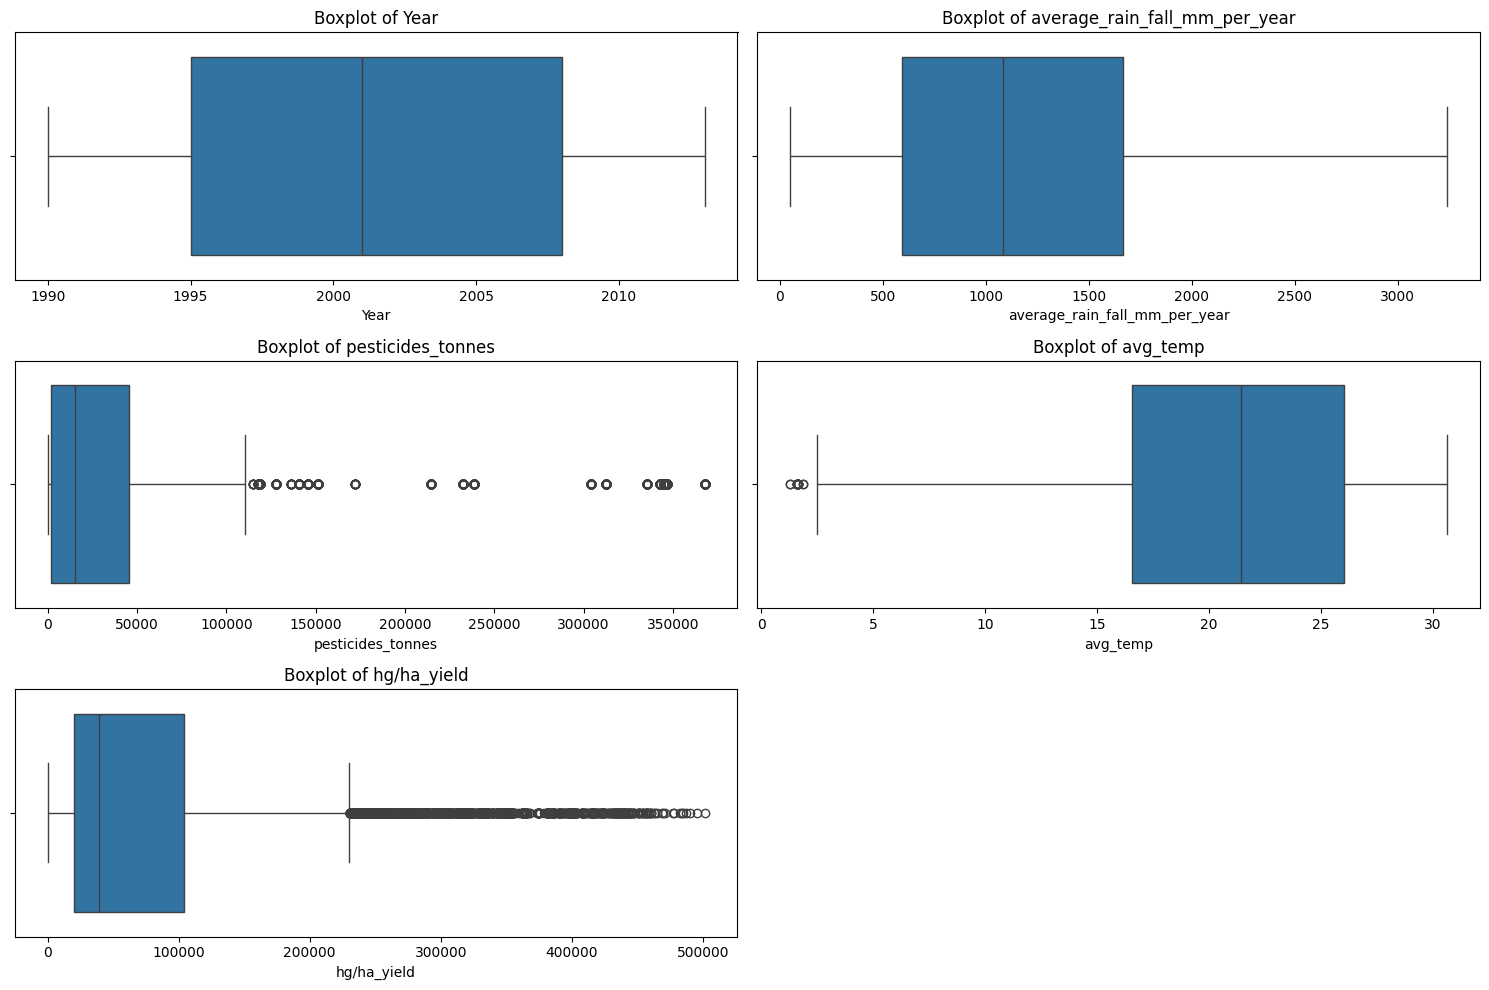

In [22]:
# --- Detailed Outlier Analysis ---
# Boxplots to visualize outliers
plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(3, 2, i)
    sns.boxplot(x=df[col])
    plt.title(f'Boxplot of {col}')
plt.tight_layout()
plt.show()

In [23]:
# IQR-based outlier detection and removal
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    print(f"\nOutliers in {column}:")
    print(f"Lower Bound: {lower_bound:.2f}, Upper Bound: {upper_bound:.2f}")
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)][column]
    print(f"Number of Outliers: {len(outliers)}")
    df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    return df

# Apply outlier removal to numerical columns
for col in numerical_cols:
    df = remove_outliers(df, col)

print("\nDataset Shape After Outlier Removal:", df.shape)


Outliers in Year:
Lower Bound: 1975.50, Upper Bound: 2027.50
Number of Outliers: 0

Outliers in average_rain_fall_mm_per_year:
Lower Bound: -1019.50, Upper Bound: 3280.50
Number of Outliers: 0

Outliers in pesticides_tonnes:
Lower Bound: -64437.50, Upper Bound: 111654.50
Number of Outliers: 1262

Outliers in avg_temp:
Lower Bound: 1.77, Upper Bound: 40.62
Number of Outliers: 14

Outliers in hg/ha_yield:
Lower Bound: -104924.50, Upper Bound: 226783.50
Number of Outliers: 1941

Dataset Shape After Outlier Removal: (22715, 8)


# Feature Engineering and Target Preparation

This cell performs feature engineering by one-hot encoding categorical variables and categorizing the target variable (hg/ha_yield) into Low, Medium, and High using terciles.

In [24]:
# --- Feature Engineering ---
# One-hot encode categorical variables
X = pd.get_dummies(df[['Area', 'Item', 'Year', 'average_rain_fall_mm_per_year', 'pesticides_tonnes', 'avg_temp']],
                   columns=['Area', 'Item'], drop_first=True)

# Define target and categorize yield into Low, Medium, High using terciles
y = df['hg/ha_yield']
y_categories = pd.qcut(y, q=3, labels=['Low', 'Medium', 'High'])

# Check class distribution
print("\nClass Distribution After Cleaning:")
print(y_categories.value_counts(normalize=True))


Class Distribution After Cleaning:
hg/ha_yield
Low       0.333348
High      0.333348
Medium    0.333304
Name: proportion, dtype: float64


# Split Data into Training and Test Sets

In [25]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y_categories, test_size=0.2, random_state=42)

# Model Evaluation

In [26]:
# --- Model Training and Evaluation ---
# Dictionary to store model performance
model_results = {}

# helper Function to evaluate and plot confusion matrix
def evaluate_model(model, model_name, X_train, X_test, y_train, y_test):
    # Fit the model
    model.fit(X_train, y_train)

    # Predict on test set
    y_pred = model.predict(X_test)

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    # Store results
    model_results[model_name] = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'model': model
    }

    # Print metrics
    print(f"\n{model_name} Single Split Metrics:")
    print(f"Accuracy: {accuracy:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1 Score: {f1:.2f}")

    # Per-class metrics
    print(f"\n{model_name} Per-Class Metrics (Single Split):")
    for label in ['Low', 'Medium', 'High']:
        precision = precision_score(y_test, y_pred, labels=[label], average='weighted')
        recall = recall_score(y_test, y_pred, labels=[label], average='weighted')
        f1 = f1_score(y_test, y_pred, labels=[label], average='weighted')
        print(f"{label}:")
        print(f"  Precision: {precision:.2f}")
        print(f"  Recall: {recall:.2f}")
        print(f"  F1: {f1:.2f}")

    # Cross-validation accuracy
    scores = cross_val_score(model, X, y_categories, cv=5, scoring='accuracy')
    print(f"\n{model_name} Cross-Validation Results:")
    print("Fold Scores:", scores)
    print(f"Cross-Validation Accuracy: {scores.mean():.2f} (±{scores.std():.2f})")
    model_results[model_name]['cv_accuracy'] = scores.mean()

    # Confusion Matrix (Cross-Validation)
    y_pred_cv = cross_val_predict(model, X, y_categories, cv=5)
    cm_cv = confusion_matrix(y_categories, y_pred_cv, labels=['Low', 'Medium', 'High'])
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_cv, annot=True, fmt='d', cmap='Blues', xticklabels=['Low', 'Medium', 'High'], yticklabels=['Low', 'Medium', 'High'])
    plt.title(f"Confusion Matrix (Cross-Validation) - {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

# Logistic Regression (L1 Regularization)


Logistic Regression (L1) Single Split Metrics:
Accuracy: 0.82
Precision: 0.82
Recall: 0.82
F1 Score: 0.82

Logistic Regression (L1) Per-Class Metrics (Single Split):
Low:
  Precision: 0.80
  Recall: 0.88
  F1: 0.84
Medium:
  Precision: 0.78
  Recall: 0.68
  F1: 0.73
High:
  Precision: 0.88
  Recall: 0.92
  F1: 0.90

Logistic Regression (L1) Cross-Validation Results:
Fold Scores: [0.58551618 0.55580013 0.72947392 0.5729694  0.55381906]
Cross-Validation Accuracy: 0.60 (±0.07)


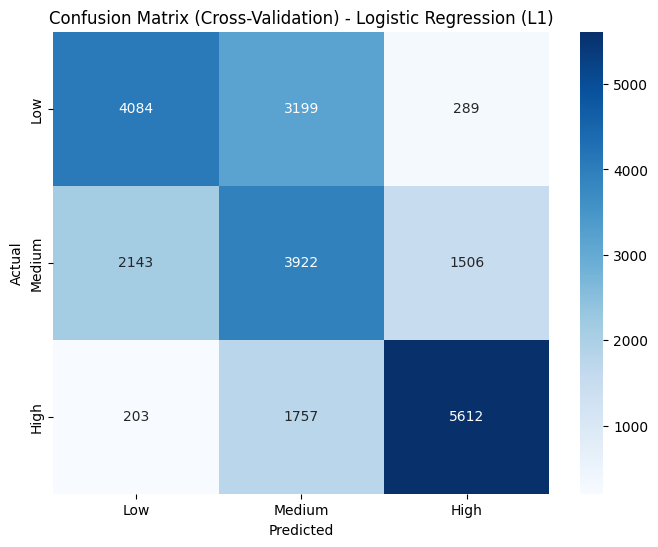

In [27]:
# 1. Logistic Regression with L1 Regularization
lr_l1_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(penalty='l1', solver='liblinear', class_weight='balanced', random_state=42))
])
evaluate_model(lr_l1_pipeline, "Logistic Regression (L1)", X_train, X_test, y_train, y_test)


Random Forest Single Split Metrics:
Accuracy: 0.76
Precision: 0.76
Recall: 0.76
F1 Score: 0.76

Random Forest Per-Class Metrics (Single Split):
Low:
  Precision: 0.75
  Recall: 0.80
  F1: 0.77
Medium:
  Precision: 0.66
  Recall: 0.66
  F1: 0.66
High:
  Precision: 0.87
  Recall: 0.81
  F1: 0.84

Random Forest Cross-Validation Results:
Fold Scores: [0.59520141 0.62887959 0.76557341 0.68368919 0.59872331]
Cross-Validation Accuracy: 0.65 (±0.06)


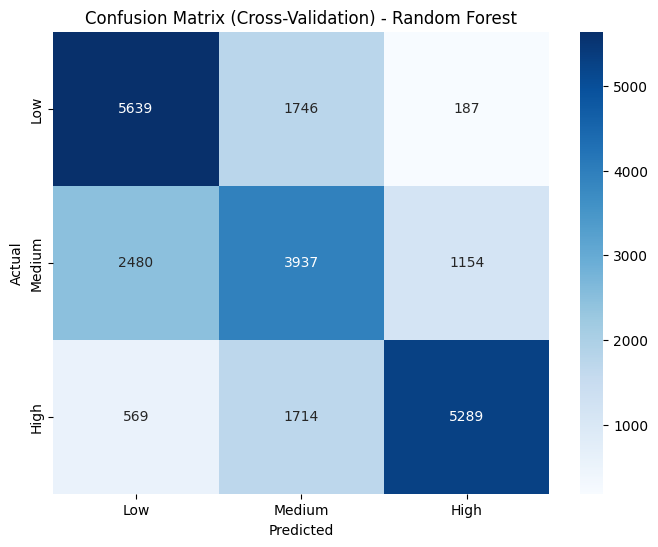

In [30]:
# 2. Random Forest with Regularization
rf_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', RandomForestClassifier(n_estimators=100, max_depth=4, min_samples_split=10, class_weight='balanced', random_state=42))
])
evaluate_model(rf_pipeline, "Random Forest", X_train, X_test, y_train, y_test)


Neural Network (L1/L2) Single Split Metrics:
Accuracy: 0.95
Precision: 0.95
Recall: 0.95
F1 Score: 0.95

Neural Network (L1/L2) Per-Class Metrics (Single Split):
Low:
  Precision: 0.95
  Recall: 0.96
  F1: 0.96
Medium:
  Precision: 0.94
  Recall: 0.91
  F1: 0.93
High:
  Precision: 0.96
  Recall: 0.98
  F1: 0.97

Neural Network (L1/L2) Cross-Validation Results:
Fold Scores: [0.59564165 0.62007484 0.70702179 0.5588818  0.56020251]
Cross-Validation Accuracy: 0.61 (±0.05)


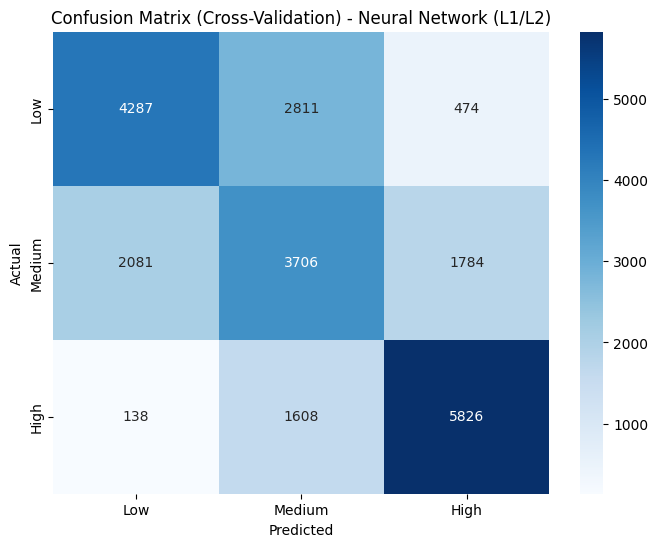

In [31]:
# 3. Neural Network with L1 and L2 Regularization
nn_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', MLPClassifier(hidden_layer_sizes=(100,), alpha=0.01, solver='adam', max_iter=500, random_state=42))
])
evaluate_model(nn_pipeline, "Neural Network (L1/L2)", X_train, X_test, y_train, y_test)

In [32]:
# Compare models and select the best
print("\nModel Comparison:")
for model_name, metrics in model_results.items():
    print(f"{model_name}:")
    print(f"  Single Split Accuracy: {metrics['accuracy']:.2f}")
    print(f"  Cross-Validation Accuracy: {metrics['cv_accuracy']:.2f}")
    print(f"  F1 Score: {metrics['f1']:.2f}")

# Select the best model based on cross-validation accuracy
best_model_name = max(model_results, key=lambda x: model_results[x]['cv_accuracy'])
best_model = model_results[best_model_name]['model']
print(f"\nBest Model: {best_model_name}")
print(f"Cross-Validation Accuracy: {model_results[best_model_name]['cv_accuracy']:.2f}")

# Save the best model
joblib.dump(best_model, 'yieldclassifier_model.pkl')
print("Best model saved as 'cropyield_model.pkl'")

#  save the scaler
scaler = best_model.named_steps['scaler']
joblib.dump(scaler, 'yieldscaler.pkl')
print("Scaler saved as 'scaler.pkl'")


Model Comparison:
Logistic Regression (L1):
  Single Split Accuracy: 0.82
  Cross-Validation Accuracy: 0.60
  F1 Score: 0.82
Logistic Regression (L2):
  Single Split Accuracy: 0.84
  Cross-Validation Accuracy: 0.60
  F1 Score: 0.84
Random Forest:
  Single Split Accuracy: 0.76
  Cross-Validation Accuracy: 0.65
  F1 Score: 0.76
Neural Network (L1/L2):
  Single Split Accuracy: 0.95
  Cross-Validation Accuracy: 0.61
  F1 Score: 0.95

Best Model: Random Forest
Cross-Validation Accuracy: 0.65
Best model saved as 'cropyield_model.pkl'
Scaler saved as 'scaler.pkl'


# Feature Importance

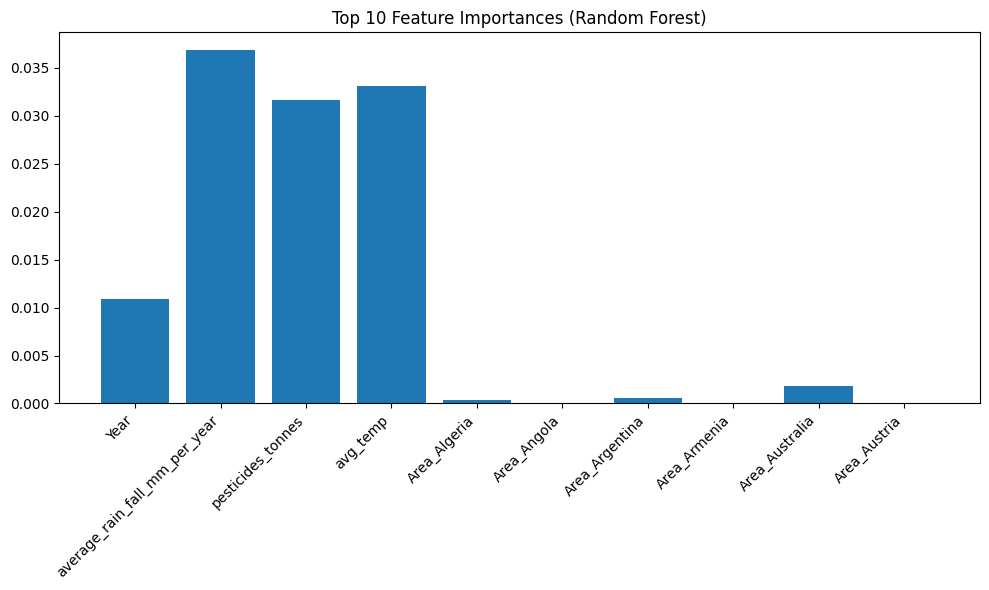

In [33]:
# Feature Importance (for Random Forest, if applicable)
if "Random Forest" in best_model_name:
    importances = best_model.named_steps['classifier'].feature_importances_
    features = X.columns
    plt.figure(figsize=(10, 6))
    plt.bar(features[:10], importances[:10])
    plt.xticks(rotation=45, ha='right')
    plt.title("Top 10 Feature Importances (Random Forest)")
    plt.tight_layout()
    plt.show()